In [98]:
import os
import gc
import traceback
import numpy as np
import pandas as pd
import seaborn as sns
# import gresearch_crypto
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
from tensorflow.keras import layers
# import tensorflow_probability as tfp # -> Error : annot import name 'naming' from 'tensorflow.python.autograph.core' 
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
pd.set_option('display.max_columns', None)

# relative imports
# from get_feats import get_features
from helperfuncs import get_time_fractions

#basics 
from datetime import datetime

In [99]:
def get_features(DATA_ROOT, nrows):
    df = pd.read_csv(DATA_ROOT+"train.csv", nrows=nrows)

    assets = pd.read_csv(DATA_ROOT+"asset_details.csv")
    df_grouped = df.groupby("Asset_ID")

    # we will work with other 12 assets
    btc = df_grouped.get_group(1)
    eth = df_grouped.get_group(6)

    btc.set_index("timestamp", inplace=True)
    btc = btc.drop(columns=["Target", "Asset_ID"])
    btc = btc.add_suffix("_btc")
    eth.set_index("timestamp", inplace=True)
    eth = eth.drop(columns=["Target", "Asset_ID"])
    eth = eth.add_suffix("_eth")

    btc_eth = pd.concat([btc, eth], axis=1)
    #filling nans for now(reindex and drop later)
    btc_eth.fillna(method="ffill", inplace=True)

    df_features = btc_eth.copy()
    suffixes = ["_btc", "_eth"]
    for suffix in suffixes:
        df_features["logprice"+suffix] = np.log(df_features["Close"+suffix]) 
        df_features["Volatility"+suffix] = np.log(df_features["High"+suffix])\
            - np.log(df_features["Close"+suffix])
        df_features = df_features.drop(columns=["Close"+suffix, "High"+suffix,\
            "Low"+suffix, "Open"+suffix, "VWAP"+suffix])

    datetimes = pd.Series(df_features.index).astype("datetime64[s]")
    df_features["frac_day"], df_features["frac_week"], df_features['frac_of_month'], \
        df_features['frac_of_year'] = zip(*datetimes.map(get_time_fractions))


    # calculate 2-asset targets(not 14 asset target)
    df_logprices = df_features[["logprice_btc", "logprice_eth"]]
    # 𝑅𝑎(𝑡)=𝑙𝑜𝑔(𝑃𝑎(𝑡+16) / 𝑃𝑎(𝑡+1))=𝑙𝑜𝑔(𝑃𝑎(𝑡+16)−𝑙𝑜𝑔(𝑃𝑎(𝑡+1)
    df_returns = df_logprices.shift(-16) - df_logprices.shift(-1)
    for suffix in suffixes:
        df_returns.rename(columns={"logprice"+suffix : "R"+suffix}, inplace=True)

    # find a better way to write next line
    assets =  assets[(assets["Asset_ID"] == 1) | (assets["Asset_ID"] == 6)]
    assets = assets.sort_values(by=["Asset_ID"])
    weights = assets["Weight"].to_numpy()
    weights = weights.reshape(len(weights), 1)


    R = df_returns.to_numpy()# to array
    weights_sum = np.sum(weights)
    M = np.dot(R, weights) / weights_sum # weighted average => log_btc*w_btc + log_eth*w_eth
    df_M = pd.DataFrame(data=M, index=df_returns.index, columns=["M"])
    R.shape,weights.shape, M.shape


    df_R_M = df_returns.copy()
    for col in df_R_M.columns:
        df_R_M[col] = df_R_M[col] * df_M["M"] # calculated R・M here
    for suffix in suffixes:
        df_R_M.rename(columns={"R"+suffix:"R_M"+suffix}, inplace=True)
    df_R_M_rolling = df_R_M.rolling(window=3750).mean()


    # creating M^2 
    df_M2 = df_M ** 2
    df_M2.rename(columns={"M" : "M2"}, inplace = True)
    df_M2_rolling = df_M2.rolling(window=3750).mean()
    df_betas = df_R_M_rolling.copy()    
    for col in df_betas.columns: # columns = [R_M_btc	R_M_eth]   
        df_betas[col] = df_betas[col] / df_M2_rolling["M2"] # caculating <R・M>/<M^2> here
    for suffix in suffixes: # beta = <R・M>/<M^2> 
        df_betas.rename(columns={"R_M"+suffix : "beta"+suffix}, inplace = True)
    df_targets = df_returns.copy()
    for suffix in suffixes:
        df_targets["R"+suffix] -= df_betas["beta"+suffix] * df_M["M"] # R^a - β^a
        df_targets.rename(columns={"R"+suffix: "Target"+suffix}, inplace=True)

    df_features_targets = pd.concat([df_features, df_betas, df_targets], axis=1)
    df_features_targets = df_features_targets.iloc[3750:-16] # drop nan rows

    df_features_targets["datetime"] = df_features_targets.index
    df_features_targets["datetime"] = df_features_targets["datetime"].apply(datetime.fromtimestamp)

    return df_features_targets

In [9]:
DATA_ROOT = "../data/"

DEVICE = "CPU"
SEED = 42
EPOCHS = 10
DEBUG = True
N_ASSETS = 14
WINDOW_SIZE = 15
BATCH_SIZE = 1024
PCT_VALIDATION = 10


In [100]:
week_secs = 60*60*24*7
month_secs = 60*60*24*31
day_secs = 60*60*24
# because dataset is formed by 14 assets
df = get_features(DATA_ROOT, nrows=week_secs)
# df.index.apply(pd.to_datetime)

In [104]:
df

,Count_btc,Volume_btc,Count_eth,Volume_eth,logprice_btc,Volatility_btc,logprice_eth,Volatility_eth,frac_day,frac_week,frac_of_month,frac_of_year,beta_btc,beta_eth,Target_btc,Target_eth,datetime
timestamp,,,,,,,,,,,,,,,,,
1514989860,580.0,109.791491,223.0,329.901996,9.617336,0.010023,6.772239,0.007694,0.604861,0.372123,0.084028,0.007137,0.982478,1.020155,-0.001043,0.001199,2018-01-03 23:31:00
1514989920,248.0,24.724641,218.0,170.856047,9.616709,0.013669,6.773209,0.005485,0.605556,0.372222,0.084050,0.007139,0.982038,1.020660,-0.001571,0.001807,2018-01-03 23:32:00
1514989980,225.0,50.562247,134.0,161.003980,9.617417,0.009942,6.773223,0.005095,0.606250,0.372321,0.084073,0.007140,0.981861,1.020864,-0.001181,0.001358,2018-01-03 23:33:00
1514990040,223.0,35.199453,275.0,225.537830,9.617911,0.010482,6.773655,0.006267,0.606944,0.372421,0.084095,0.007142,0.981713,1.021034,-0.001245,0.001432,2018-01-03 23:34:00
1514990100,386.0,67.987783,189.0,302.293089,9.617057,0.011335,6.773647,0.006309,0.607639,0.372520,0.084117,0.007144,0.981607,1.021156,-0.001071,0.001232,2018-01-03 23:35:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519280160,518.0,82.364577,249.0,291.356186,9.292534,0.003434,6.766161,0.003274,0.261111,0.465873,0.759325,0.143181,1.086634,0.900351,0.001048,-0.001205,2018-02-22 15:16:00
1519280220,291.0,48.245749,183.0,163.277760,9.292212,0.004306,6.766038,0.003604,0.261806,0.465972,0.759350,0.143183,1.086662,0.900319,0.001117,-0.001285,2018-02-22 15:17:00
1519280280,348.0,61.889567,246.0,283.193914,9.293158,0.003314,6.766624,0.003018,0.262500,0.466071,0.759375,0.143185,1.086666,0.900314,0.001011,-0.001162,2018-02-22 15:18:00


In [95]:
df = get_features_(DATA_ROOT, week_secs)  

btc (75275, 10)


,Count_btc,Volume_btc,Count_eth,Volume_eth,logprice_btc,Volatility_btc,logprice_eth,Volatility_eth,frac_day,frac_week,frac_of_month,frac_of_year,beta_btc,beta_eth,Target_btc,Target_eth,datetime
timestamp,,,,,,,,,,,,,,,,,
1514989860,580.0,109.791491,223.0,329.901996,9.617336,0.010023,6.772239,0.007694,0.604861,0.372123,0.084028,0.007137,0.982478,1.020155,-0.001043,0.001199,2018-01-03 23:31:00
1514989920,248.0,24.724641,218.0,170.856047,9.616709,0.013669,6.773209,0.005485,0.605556,0.372222,0.084050,0.007139,0.982038,1.020660,-0.001571,0.001807,2018-01-03 23:32:00
1514989980,225.0,50.562247,134.0,161.003980,9.617417,0.009942,6.773223,0.005095,0.606250,0.372321,0.084073,0.007140,0.981861,1.020864,-0.001181,0.001358,2018-01-03 23:33:00
1514990040,223.0,35.199453,275.0,225.537830,9.617911,0.010482,6.773655,0.006267,0.606944,0.372421,0.084095,0.007142,0.981713,1.021034,-0.001245,0.001432,2018-01-03 23:34:00
1514990100,386.0,67.987783,189.0,302.293089,9.617057,0.011335,6.773647,0.006309,0.607639,0.372520,0.084117,0.007144,0.981607,1.021156,-0.001071,0.001232,2018-01-03 23:35:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519280160,518.0,82.364577,249.0,291.356186,9.292534,0.003434,6.766161,0.003274,0.261111,0.465873,0.759325,0.143181,1.086634,0.900351,0.001048,-0.001205,2018-02-22 15:16:00
1519280220,291.0,48.245749,183.0,163.277760,9.292212,0.004306,6.766038,0.003604,0.261806,0.465972,0.759350,0.143183,1.086662,0.900319,0.001117,-0.001285,2018-02-22 15:17:00
1519280280,348.0,61.889567,246.0,283.193914,9.293158,0.003314,6.766624,0.003018,0.262500,0.466071,0.759375,0.143185,1.086666,0.900314,0.001011,-0.001162,2018-02-22 15:18:00


In [69]:
# dimension reduction and keeping only one date
df_features_targets.drop(columns=["datetime_eth", "beta_eth" ,"Target_eth"], inplace=True)

,Count_btc,Volume_btc,datetime_btc,Count_eth,Volume_eth,datetime_eth,logprice_btc,Volatility_btc,logprice_eth,Volatility_eth,frac_day,frac_week,frac_of_month,frac_of_year,beta_btc,beta_eth,Target_btc,Target_eth
timestamp,,,,,,,,,,,,,,,,,,
1514989860,580.0,109.791491,2018-01-03 23:31:00,223.0,329.901996,2018-01-03 23:31:00,9.617336,0.010023,6.772239,0.007694,0.604861,0.372123,0.084028,0.007137,0.982478,1.020155,-0.001043,0.001199
1514989920,248.0,24.724641,2018-01-03 23:32:00,218.0,170.856047,2018-01-03 23:32:00,9.616709,0.013669,6.773209,0.005485,0.605556,0.372222,0.084050,0.007139,0.982038,1.020660,-0.001571,0.001807
1514989980,225.0,50.562247,2018-01-03 23:33:00,134.0,161.003980,2018-01-03 23:33:00,9.617417,0.009942,6.773223,0.005095,0.606250,0.372321,0.084073,0.007140,0.981861,1.020864,-0.001181,0.001358
1514990040,223.0,35.199453,2018-01-03 23:34:00,275.0,225.537830,2018-01-03 23:34:00,9.617911,0.010482,6.773655,0.006267,0.606944,0.372421,0.084095,0.007142,0.981713,1.021034,-0.001245,0.001432
1514990100,386.0,67.987783,2018-01-03 23:35:00,189.0,302.293089,2018-01-03 23:35:00,9.617057,0.011335,6.773647,0.006309,0.607639,0.372520,0.084117,0.007144,0.981607,1.021156,-0.001071,0.001232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519280160,518.0,82.364577,2018-02-22 15:16:00,249.0,291.356186,2018-02-22 15:16:00,9.292534,0.003434,6.766161,0.003274,0.261111,0.465873,0.759325,0.143181,1.086634,0.900351,0.001048,-0.001205
1519280220,291.0,48.245749,2018-02-22 15:17:00,183.0,163.277760,2018-02-22 15:17:00,9.292212,0.004306,6.766038,0.003604,0.261806,0.465972,0.759350,0.143183,1.086662,0.900319,0.001117,-0.001285
1519280280,348.0,61.889567,2018-02-22 15:18:00,246.0,283.193914,2018-02-22 15:18:00,9.293158,0.003314,6.766624,0.003018,0.262500,0.466071,0.759375,0.143185,1.086666,0.900314,0.001011,-0.001162


<AxesSubplot:xlabel='timestamp'>

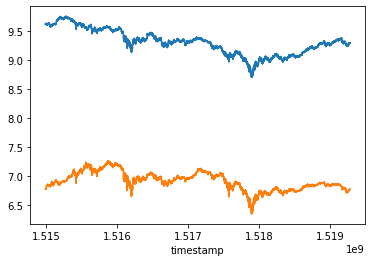

In [29]:
df.logprice_btc.plot()
df.logprice_eth.plot()